In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean

import os
import sys
sys.path.append(os.path.realpath("../modules"))
from utils import train_test_split
sys.path.append(os.path.realpath("./"))
from preprocessing import *

import warnings
warnings.filterwarnings("ignore")#, category=UserWarning)

# Set parameters

In [2]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = 500
forecast_horizon = 24
n_lags = 48

# Import Data

In [3]:
df = pd.read_csv(
    "../data/consumption.csv", usecols=["prediction_unit_id", "datetime", "target"]
)[["prediction_unit_id", "datetime", "target"]].rename(
    columns={"prediction_unit_id": "unique_id", "datetime": "ds", "target": "y"}
)
df["ds"] = pd.to_datetime(df["ds"])
df.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [4]:
df.shape

(1009176, 3)

In [5]:
df.isna().sum()

unique_id      0
ds             0
y            264
dtype: int64

In [6]:
df[(df["unique_id"] == 0) & (df["ds"] > "2021-10-31 00:00:00") & (df["ds"] < "2021-10-31 05:00:00")]

,unique_id,ds,y
89343,0,2021-10-31 01:00:00,170.490
89406,0,2021-10-31 02:00:00,166.141
89469,0,2021-10-31 03:00:00,NaN
89532,0,2021-10-31 04:00:00,174.856


In [7]:
df = df.sort_values(["unique_id", "ds"]).ffill()

In [8]:
df[(df["unique_id"] == 0) & (df["ds"] > "2021-10-31 00:00:00") & (df["ds"] < "2021-10-31 05:00:00")]

,unique_id,ds,y
89343,0,2021-10-31 01:00:00,170.490
89406,0,2021-10-31 02:00:00,166.141
89469,0,2021-10-31 03:00:00,166.141
89532,0,2021-10-31 04:00:00,174.856


In [9]:
df["y"] = df["y"].ffill()
df.isna().sum()

unique_id    0
ds           0
y            0
dtype: int64

# Train/Test split

In [10]:
# taking the last 60 days of each unit for test
df_train, df_test = train_test_split(df, test_window=24*60)

In [11]:
df.shape[0] == df_train.shape[0] + df_test.shape[0]

True

In [12]:
df.shape[1] == df_train.shape[1] == df_test.shape[1]

True

In [13]:
test_size = df_test.shape[0] / (df.shape[0])
print(f"test set : {round(test_size*100, 2)}% of the data set")

test set : 9.85% of the data set


# Test preprocessing

## Test computed features

In [15]:
fcst = MLForecast(
    models=[],
    freq="h",
    lags=[i + 1 for i in range(2)],
    lag_transforms={
        1: [ExpandingMean(), RollingMean(window_size=24)],
    },
    date_features=["month", "dayofweek", "hour"],
)

X = fcst.preprocess(df)
print(X.shape)
X.head()

(1007520, 10)


,unique_id,ds,y,lag1,lag2,expanding_mean_lag1,rolling_mean_lag1_window_size24,month,dayofweek,hour
1464,0,2021-09-02 00:00:00,109.366,127.531,129.917,79.969750,79.969750,9,3,0
1525,0,2021-09-02 01:00:00,97.033,109.366,127.531,81.145600,80.502083,9,3,1
1586,0,2021-09-02 02:00:00,104.854,97.033,109.366,81.756654,81.308000,9,3,2
1647,0,2021-09-02 03:00:00,103.433,104.854,97.033,82.612111,81.860500,9,3,3
1708,0,2021-09-02 04:00:00,105.858,103.433,104.854,83.355714,82.505417,9,3,4


In [16]:
X.iloc[0, 1]

Timestamp('2021-09-02 00:00:00')

In [17]:
df["y"].rolling(window=24).mean().dropna().head()

1403    79.969750
1464    80.502083
1525    81.308000
1586    81.860500
1647    82.505417
Name: y, dtype: float64

In [18]:
(df["y"].rolling(window=24).mean().dropna().head(1000).reset_index()["y"].round() == X.head(1000).reset_index()["rolling_mean_lag1_window_size24"].round()).unique()

array([ True])

In [19]:
(df["y"].expanding().mean().iloc[(forecast_horizon-1):].head(1000).reset_index()["y"].round() == X.head(1000).reset_index()["expanding_mean_lag1"].round()).unique()

array([ True])

## Test preprocessing for training

In [20]:
fcst = MLForecast(
    models=[],
    freq="h",
    lags=[i + forecast_horizon for i in range(n_lags)],
    lag_transforms={
        i+forecast_horizon: [ExpandingMean(), RollingMean(window_size=24)] for i in range(24)
    },
    date_features=["month", "dayofweek", "hour"],
)

X = fcst.preprocess(df)
print(X.shape)
X.head()

(1004277, 102)


,unique_id,ds,y,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,expanding_mean_lag24,rolling_mean_lag24_window_size24,expanding_mean_lag25,rolling_mean_lag25_window_size24,expanding_mean_lag26,rolling_mean_lag26_window_size24,expanding_mean_lag27,rolling_mean_lag27_window_size24,expanding_mean_lag28,rolling_mean_lag28_window_size24,expanding_mean_lag29,rolling_mean_lag29_window_size24,expanding_mean_lag30,rolling_mean_lag30_window_size24,expanding_mean_lag31,rolling_mean_lag31_window_size24,expanding_mean_lag32,rolling_mean_lag32_window_size24,expanding_mean_lag33,rolling_mean_lag33_window_size24,expanding_mean_lag34,rolling_mean_lag34_window_size24,expanding_mean_lag35,rolling_mean_lag35_window_size24,expanding_mean_lag36,rolling_mean_lag36_window_size24,expanding_mean_lag37,rolling_mean_lag37_window_size24,expanding_mean_lag38,rolling_mean_lag38_window_size24,expanding_mean_lag39,rolling_mean_lag39_window_size24,expanding_mean_lag40,rolling_mean_lag40_window_size24,expanding_mean_lag41,rolling_mean_lag41_window_size24,expanding_mean_lag42,rolling_mean_lag42_window_size24,expanding_mean_lag43,rolling_mean_lag43_window_size24,expanding_mean_lag44,rolling_mean_lag44_window_size24,expanding_mean_lag45,rolling_mean_lag45_window_size24,expanding_mean_lag46,rolling_mean_lag46_window_size24,expanding_mean_lag47,rolling_mean_lag47_window_size24,month,dayofweek,hour
4331,0,2021-09-03 23:00:00,139.929,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,77.691,96.590,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.612970,84.377167,86.003875,84.552333,85.716806,84.539375,84.841667,83.893958,84.131655,83.241833,83.355714,82.505417,82.612111,81.860500,81.756654,81.308000,81.145600,80.502083,9,4,23
4392,0,2021-09-04 00:00:00,121.942,107.129,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,77.691,84.112898,87.203833,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.612970,84.377167,86.003875,84.552333,85.716806,84.539375,84.841667,83.893958,84.131655,83.241833,83.355714,82.505417,82.612111,81.860500,81.756654,81.308000,9,5,0
4453,0,2021-09-04 01:00:00,114.038,81.920,107.129,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,84.069040,86.574125,84.112898,87.203833,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,

In [21]:
X, y = X.iloc[:, 3:], X["y"]
print(X.shape)
print(y.shape)

(1004277, 99)
(1004277,)


In [22]:
X.head()

,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,expanding_mean_lag24,rolling_mean_lag24_window_size24,expanding_mean_lag25,rolling_mean_lag25_window_size24,expanding_mean_lag26,rolling_mean_lag26_window_size24,expanding_mean_lag27,rolling_mean_lag27_window_size24,expanding_mean_lag28,rolling_mean_lag28_window_size24,expanding_mean_lag29,rolling_mean_lag29_window_size24,expanding_mean_lag30,rolling_mean_lag30_window_size24,expanding_mean_lag31,rolling_mean_lag31_window_size24,expanding_mean_lag32,rolling_mean_lag32_window_size24,expanding_mean_lag33,rolling_mean_lag33_window_size24,expanding_mean_lag34,rolling_mean_lag34_window_size24,expanding_mean_lag35,rolling_mean_lag35_window_size24,expanding_mean_lag36,rolling_mean_lag36_window_size24,expanding_mean_lag37,rolling_mean_lag37_window_size24,expanding_mean_lag38,rolling_mean_lag38_window_size24,expanding_mean_lag39,rolling_mean_lag39_window_size24,expanding_mean_lag40,rolling_mean_lag40_window_size24,expanding_mean_lag41,rolling_mean_lag41_window_size24,expanding_mean_lag42,rolling_mean_lag42_window_size24,expanding_mean_lag43,rolling_mean_lag43_window_size24,expanding_mean_lag44,rolling_mean_lag44_window_size24,expanding_mean_lag45,rolling_mean_lag45_window_size24,expanding_mean_lag46,rolling_mean_lag46_window_size24,expanding_mean_lag47,rolling_mean_lag47_window_size24,month,dayofweek,hour
4331,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,77.691,96.590,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.612970,84.377167,86.003875,84.552333,85.716806,84.539375,84.841667,83.893958,84.131655,83.241833,83.355714,82.505417,82.612111,81.860500,81.756654,81.308000,81.145600,80.502083,9,4,23
4392,107.129,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,77.691,84.112898,87.203833,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.612970,84.377167,86.003875,84.552333,85.716806,84.539375,84.841667,83.893958,84.131655,83.241833,83.355714,82.505417,82.612111,81.860500,81.756654,81.308000,9,5,0
4453,81.920,107.129,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,84.069040,86.574125,84.112898,87.203833,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.61

In [23]:
y.head()

4331    139.929
4392    121.942
4453    114.038
4514    105.102
4575    120.120
Name: y, dtype: float64

## Test preprocessing for inference

In [24]:
mask = (df["ds"] >= df["ds"].min()) & (df["ds"] < df.ds.min() + pd.DateOffset(hours=n_lags))
ts = df[mask]
print("shape :", ts.shape)
print("# units :", ts.shape[0]/n_lags)
print("# rows per unit :", ts.groupby("unique_id").size().unique())

shape : (2928, 3)
# units : 61.0
# rows per unit : [48]


In [25]:
timedeltas = []
for id in ts["unique_id"].unique():
    timedeltas.append((ts.loc[ts["unique_id"] == 0, "ds"] - ts.loc[ts["unique_id"] == 0, "ds"].shift(1)).dropna().unique())

In [27]:
pd.Series(timedeltas).explode().unique()

<TimedeltaArray>
['0 days 01:00:00']
Length: 1, dtype: timedelta64[ns]

In [29]:
unique_ids = ts["unique_id"].unique()
# add rows between the last recorded value and the target
for unique_id in unique_ids:
    new_rows = pd.DataFrame(
        {
            "unique_id": unique_id,
            "ds": pd.date_range(ts["ds"].iloc[-1], periods=forecast_horizon, freq="h"),
            "y": -99, # must not be None
        }
    )
    ts = pd.concat((ts, new_rows))
print("shape :", ts.shape)
print("# units :", ts.shape[0]/(n_lags+forecast_horizon))
print("# rows per unit :", ts.groupby("unique_id").size().unique())

shape : (4392, 3)
# units : 61.0
# rows per unit : [72]


In [30]:
fcst = MLForecast(
    models=[],
    freq="h",
    lags=[i + forecast_horizon for i in range(n_lags)],
    lag_transforms={
        i+forecast_horizon: [ExpandingMean(), RollingMean(window_size=24)] for i in range(24)
    },
    date_features=["month", "dayofweek", "hour"],
)

X = fcst.preprocess(ts)
print(X.shape)
X

(61, 102)


,unique_id,ds,y,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,expanding_mean_lag24,rolling_mean_lag24_window_size24,expanding_mean_lag25,rolling_mean_lag25_window_size24,expanding_mean_lag26,rolling_mean_lag26_window_size24,expanding_mean_lag27,rolling_mean_lag27_window_size24,expanding_mean_lag28,rolling_mean_lag28_window_size24,expanding_mean_lag29,rolling_mean_lag29_window_size24,expanding_mean_lag30,rolling_mean_lag30_window_size24,expanding_mean_lag31,rolling_mean_lag31_window_size24,expanding_mean_lag32,rolling_mean_lag32_window_size24,expanding_mean_lag33,rolling_mean_lag33_window_size24,expanding_mean_lag34,rolling_mean_lag34_window_size24,expanding_mean_lag35,rolling_mean_lag35_window_size24,expanding_mean_lag36,rolling_mean_lag36_window_size24,expanding_mean_lag37,rolling_mean_lag37_window_size24,expanding_mean_lag38,rolling_mean_lag38_window_size24,expanding_mean_lag39,rolling_mean_lag39_window_size24,expanding_mean_lag40,rolling_mean_lag40_window_size24,expanding_mean_lag41,rolling_mean_lag41_window_size24,expanding_mean_lag42,rolling_mean_lag42_window_size24,expanding_mean_lag43,rolling_mean_lag43_window_size24,expanding_mean_lag44,rolling_mean_lag44_window_size24,expanding_mean_lag45,rolling_mean_lag45_window_size24,expanding_mean_lag46,rolling_mean_lag46_window_size24,expanding_mean_lag47,rolling_mean_lag47_window_size24,month,dayofweek,hour
23,0,2021-09-03 22:00:00,-99.0,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,77.691,96.590,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.612970,84.377167,86.003875,84.552333,85.716806,84.539375,84.841667,83.893958,84.131655,83.241833,83.355714,82.505417,82.612111,81.860500,81.756654,81.308000,81.14560,80.502083,9,4,22
23,1,2021-09-04 21:00:00,-99.0,19.430,21.577,24.309,27.201,25.419,18.060,16.228,10.614,8.493,8.912,6.505,5.323,5.914,10.043,10.450,12.868,17.052,20.356,18.534,17.401,17.919,17.275,15.690,21.008,20.257,24.127,23.957,22.718,17.612,18.344,13.322,12.233,8.325,6.965,7.139,6.916,10.018,8.639,11.898,17.691,13.535,17.267,19.405,18.225,14.271,16.510,15.872,17.314,15.398771,15.690875,15.313000,15.725333,15.176826,15.831583,14.973889,15.816917,14.696000,15.630125,14.446628,15.304833,14.360595,15.316667,14.315049,15.195583,14.407575,15.263042,14.559231,15.256042,14.707842,15.174917,14.929541,15.201333,15.196389,15.267708,15.461600,15.438708,15.620971,15.380208,15.777667,15.440542,15.868594,15.641500,15.830419,15.494958,15.679567,15.366250,15.581138,15.402542,15.516143,15.436875,15.427148,15.284875,15.356077,15.253000,15.34272,15.260583,9,5,21
23,2,2021-09-05 20:00:00,-99.0,748.504,920.535,1000.499,988.047,877.168,656.989,489.864,278.374,272.205,221.166,155.423,120.001,137.873,180.358,245.861,433.808,684.943,761.605,678.744,702.627,689.527,687.776,672.163,735.696,770.188,884.169,947.722,908.559,681.546,476.573,343.695,248.292,237.325,199.337,137.347,126.275,136.424,198.991,277.693,432.277,560.413,651.282,646.245,607.308,622.824,598.450,595.498,656.859,526.771833,555.823167,522.054128,556.726667,513.391500,555.211417,502.566889,553.012375,491.533250,549.700375,482.565000,541.549458,478.412048,534.032125,478.132732,527.941750,483.126700,526.688333,488.534949,525.235000,495.570974,524.325458,504.7641

# Preprocessing script

In [114]:
def preprocessing(ts, forecast_horizon=24, n_lags=48, inference=False):
    if inference == True: # add rows between the last recorded value and the target
        unique_ids = ts["unique_id"].unique()
        for unique_id in unique_ids:
            new_rows = pd.DataFrame(
                {
                    "unique_id": unique_id,
                    "ds": pd.date_range(ts["ds"].iloc[-1], periods=forecast_horizon, freq="h"),
                    "y": -99, # must not be None
                }
            )
            ts = pd.concat((ts, new_rows))
    else: # drop discontinuous time series
        ids_to_drop = [21, 26, 41, 44, 47, 68]
        ts = ts[~ts["unique_id"].isin(ids_to_drop)]

    fcst = MLForecast(
        models=[],
        freq="h",
        lags=[i + forecast_horizon for i in range(n_lags)],
        lag_transforms={
            i+forecast_horizon: [ExpandingMean(), RollingMean(window_size=24)] for i in range(24)
        },
        date_features=["month", "dayofweek", "hour"],
    )

    X = fcst.preprocess(ts)
    if inference == False:
        X, y = X.iloc[:, 3:], X["y"]
        return X, y
    else:
        return X.iloc[:, 3:]

In [115]:
mask = (df["ds"] >= df["ds"].min()) & (df["ds"] < df.ds.min() + pd.DateOffset(hours=n_lags))
ts = df[mask]
print("shape :", ts.shape)
print("# units :", ts.shape[0]/n_lags)
print("# rows per unit :", ts.groupby("unique_id").size().unique())

shape : (2928, 3)
# units : 61.0
# rows per unit : [48]


In [116]:
X = preprocessing(ts, inference=True)
X.shape

(61, 99)

In [117]:
X

,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,expanding_mean_lag24,rolling_mean_lag24_window_size24,expanding_mean_lag25,rolling_mean_lag25_window_size24,expanding_mean_lag26,rolling_mean_lag26_window_size24,expanding_mean_lag27,rolling_mean_lag27_window_size24,expanding_mean_lag28,rolling_mean_lag28_window_size24,expanding_mean_lag29,rolling_mean_lag29_window_size24,expanding_mean_lag30,rolling_mean_lag30_window_size24,expanding_mean_lag31,rolling_mean_lag31_window_size24,expanding_mean_lag32,rolling_mean_lag32_window_size24,expanding_mean_lag33,rolling_mean_lag33_window_size24,expanding_mean_lag34,rolling_mean_lag34_window_size24,expanding_mean_lag35,rolling_mean_lag35_window_size24,expanding_mean_lag36,rolling_mean_lag36_window_size24,expanding_mean_lag37,rolling_mean_lag37_window_size24,expanding_mean_lag38,rolling_mean_lag38_window_size24,expanding_mean_lag39,rolling_mean_lag39_window_size24,expanding_mean_lag40,rolling_mean_lag40_window_size24,expanding_mean_lag41,rolling_mean_lag41_window_size24,expanding_mean_lag42,rolling_mean_lag42_window_size24,expanding_mean_lag43,rolling_mean_lag43_window_size24,expanding_mean_lag44,rolling_mean_lag44_window_size24,expanding_mean_lag45,rolling_mean_lag45_window_size24,expanding_mean_lag46,rolling_mean_lag46_window_size24,expanding_mean_lag47,rolling_mean_lag47_window_size24,month,dayofweek,hour
23,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,77.691,96.590,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.612970,84.377167,86.003875,84.552333,85.716806,84.539375,84.841667,83.893958,84.131655,83.241833,83.355714,82.505417,82.612111,81.860500,81.756654,81.308000,81.14560,80.502083,9,4,22
23,19.430,21.577,24.309,27.201,25.419,18.060,16.228,10.614,8.493,8.912,6.505,5.323,5.914,10.043,10.450,12.868,17.052,20.356,18.534,17.401,17.919,17.275,15.690,21.008,20.257,24.127,23.957,22.718,17.612,18.344,13.322,12.233,8.325,6.965,7.139,6.916,10.018,8.639,11.898,17.691,13.535,17.267,19.405,18.225,14.271,16.510,15.872,17.314,15.398771,15.690875,15.313000,15.725333,15.176826,15.831583,14.973889,15.816917,14.696000,15.630125,14.446628,15.304833,14.360595,15.316667,14.315049,15.195583,14.407575,15.263042,14.559231,15.256042,14.707842,15.174917,14.929541,15.201333,15.196389,15.267708,15.461600,15.438708,15.620971,15.380208,15.777667,15.440542,15.868594,15.641500,15.830419,15.494958,15.679567,15.366250,15.581138,15.402542,15.516143,15.436875,15.427148,15.284875,15.356077,15.253000,15.34272,15.260583,9,5,21
23,748.504,920.535,1000.499,988.047,877.168,656.989,489.864,278.374,272.205,221.166,155.423,120.001,137.873,180.358,245.861,433.808,684.943,761.605,678.744,702.627,689.527,687.776,672.163,735.696,770.188,884.169,947.722,908.559,681.546,476.573,343.695,248.292,237.325,199.337,137.347,126.275,136.424,198.991,277.693,432.277,560.413,651.282,646.245,607.308,622.824,598.450,595.498,656.859,526.771833,555.823167,522.054128,556.726667,513.391500,555.211417,502.566889,553.012375,491.533250,549.700375,482.565000,541.549458,478.412048,534.032125,478.132732,527.941750,483.126700,526.688333,488.534949,525.235000,495.570974,524.325458,504.764162,523.572292,515.452028,523.833708,526.240000,523.773333,536.413000,524.549708,545.217606,525.8760

In [118]:
X, y = preprocessing(df)
print(X.shape)
print(y.shape)

(946311, 99)
(946311,)


In [119]:
X

,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,expanding_mean_lag24,rolling_mean_lag24_window_size24,expanding_mean_lag25,rolling_mean_lag25_window_size24,expanding_mean_lag26,rolling_mean_lag26_window_size24,expanding_mean_lag27,rolling_mean_lag27_window_size24,expanding_mean_lag28,rolling_mean_lag28_window_size24,expanding_mean_lag29,rolling_mean_lag29_window_size24,expanding_mean_lag30,rolling_mean_lag30_window_size24,expanding_mean_lag31,rolling_mean_lag31_window_size24,expanding_mean_lag32,rolling_mean_lag32_window_size24,expanding_mean_lag33,rolling_mean_lag33_window_size24,expanding_mean_lag34,rolling_mean_lag34_window_size24,expanding_mean_lag35,rolling_mean_lag35_window_size24,expanding_mean_lag36,rolling_mean_lag36_window_size24,expanding_mean_lag37,rolling_mean_lag37_window_size24,expanding_mean_lag38,rolling_mean_lag38_window_size24,expanding_mean_lag39,rolling_mean_lag39_window_size24,expanding_mean_lag40,rolling_mean_lag40_window_size24,expanding_mean_lag41,rolling_mean_lag41_window_size24,expanding_mean_lag42,rolling_mean_lag42_window_size24,expanding_mean_lag43,rolling_mean_lag43_window_size24,expanding_mean_lag44,rolling_mean_lag44_window_size24,expanding_mean_lag45,rolling_mean_lag45_window_size24,expanding_mean_lag46,rolling_mean_lag46_window_size24,expanding_mean_lag47,rolling_mean_lag47_window_size24,month,dayofweek,hour
4331,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,77.691,96.590,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.612970,84.377167,86.003875,84.552333,85.716806,84.539375,84.841667,83.893958,84.131655,83.241833,83.355714,82.505417,82.612111,81.860500,81.756654,81.308000,81.145600,80.502083,9,4,23
4392,107.129,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,77.691,84.112898,87.203833,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.612970,84.377167,86.003875,84.552333,85.716806,84.539375,84.841667,83.893958,84.131655,83.241833,83.355714,82.505417,82.612111,81.860500,81.756654,81.308000,9,5,0
4453,81.920,107.129,120.540,134.986,150.412,152.763,136.130,121.033,80.621,43.428,46.840,43.671,28.354,24.350,28.651,33.456,43.940,73.104,94.903,111.971,105.432,105.858,103.433,104.854,97.033,109.366,127.531,129.917,157.872,143.479,109.220,72.920,58.293,39.982,49.021,45.512,37.784,26.138,31.147,36.071,54.211,77.308,94.592,96.481,89.781,88.184,87.955,91.594,84.069040,86.574125,84.112898,87.203833,83.633396,87.297042,82.848149,87.588333,81.714717,87.377125,80.188111,87.687958,78.538682,87.301125,77.199349,86.179875,76.155690,84.175167,76.046780,83.244833,76.862250,83.101250,77.632051,83.192125,78.525763,83.268833,79.881757,83.661750,81.424306,83.736250,82.932114,83.840250,84.387294,83.949208,85.61

In [120]:
y

4331       139.929
4392       121.942
4453       114.038
4514       105.102
4575       120.120
            ...   
1008898    313.989
1008963    324.015
1009028    316.206
1009093    333.201
1009158    325.267
Name: y, Length: 946311, dtype: float64

# Revealing discontinuous data

In [53]:
lead1 = df.groupby("unique_id").shift(-1).dropna()
print(lead1.shape)
lead1.rename(columns={"ds": "ds_lead1", "y": "lead1"}, inplace=True)
lead1.head()

(1009107, 2)


,ds_lead1,lead1
0,2021-09-01 01:00:00,77.691
61,2021-09-01 02:00:00,91.594
122,2021-09-01 03:00:00,87.955
183,2021-09-01 04:00:00,88.184
244,2021-09-01 05:00:00,89.781


In [54]:
# df = df.sort_values(["unique_id", "ds"])
print(df.shape)
df.head()

(1009176, 3)


,unique_id,ds,y
0,0,2021-09-01 00:00:00,96.590
61,0,2021-09-01 01:00:00,77.691
122,0,2021-09-01 02:00:00,91.594
183,0,2021-09-01 03:00:00,87.955
244,0,2021-09-01 04:00:00,88.184


In [55]:
df_concat = pd.concat([df, lead1], axis=1).dropna()
df_concat["delta_t"] = df_concat["ds_lead1"] - df_concat["ds"]
print(df_concat.shape)
df_concat.head()

(1009107, 6)


,unique_id,ds,y,ds_lead1,lead1,delta_t
0,0,2021-09-01 00:00:00,96.590,2021-09-01 01:00:00,77.691,0 days 01:00:00
61,0,2021-09-01 01:00:00,77.691,2021-09-01 02:00:00,91.594,0 days 01:00:00
122,0,2021-09-01 02:00:00,91.594,2021-09-01 03:00:00,87.955,0 days 01:00:00
183,0,2021-09-01 03:00:00,87.955,2021-09-01 04:00:00,88.184,0 days 01:00:00
244,0,2021-09-01 04:00:00,88.184,2021-09-01 05:00:00,89.781,0 days 01:00:00


In [56]:
ids_to_drop = df_concat.loc[df_concat["delta_t"] != pd.Timedelta(hours=1), "unique_id"].unique()
ids_to_drop

array([21, 26, 41, 44, 47, 68], dtype=int64)

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot parameters
sns.set_theme()
plt.rc(
    "figure",
    autolayout=True,
    figsize=(10, 4),
    titlesize=12,
    titleweight="bold",
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=12,
    titlepad=10,
)

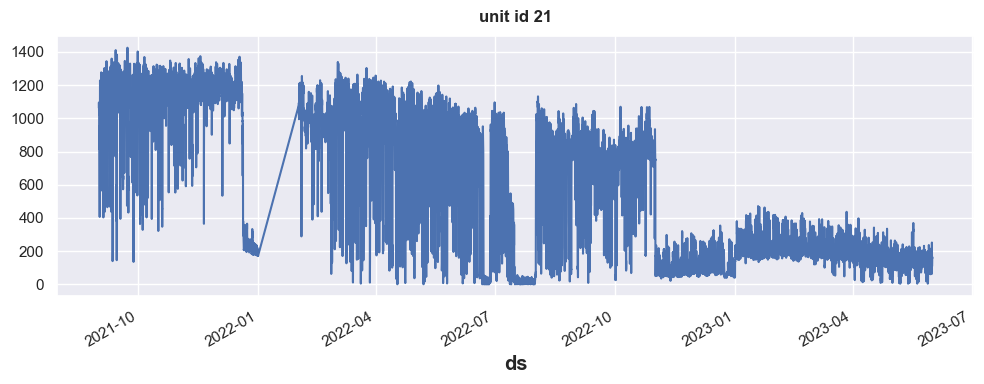

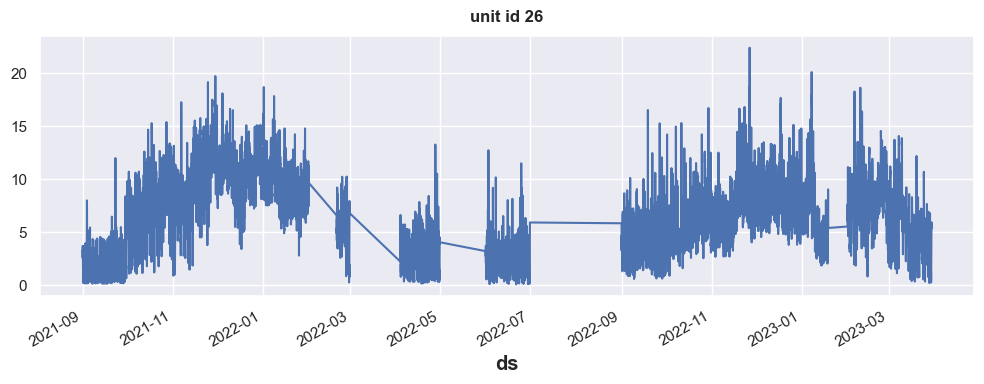

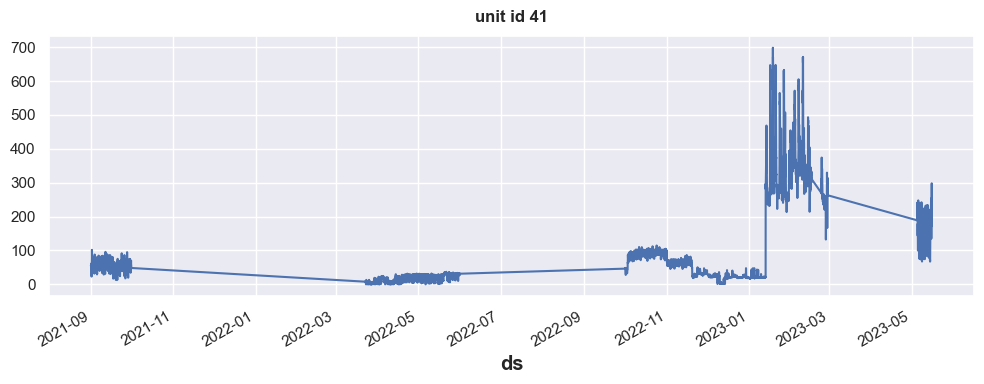

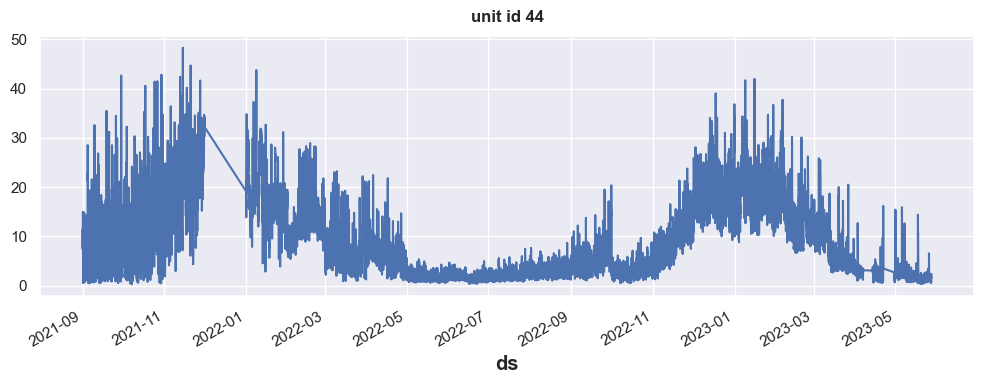

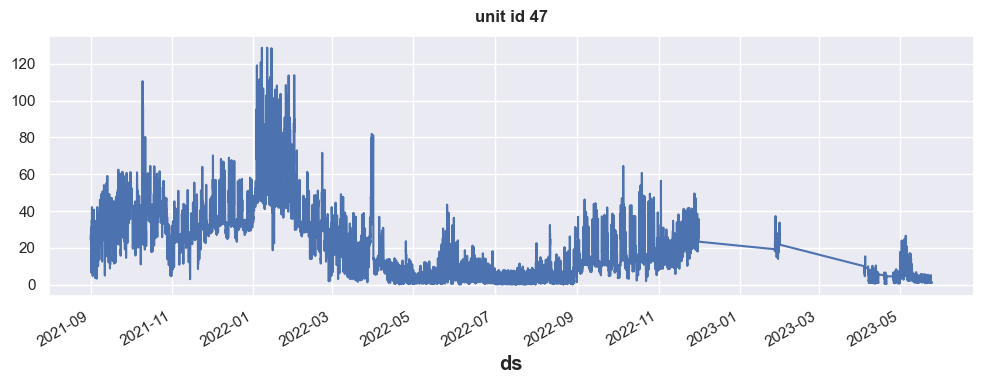

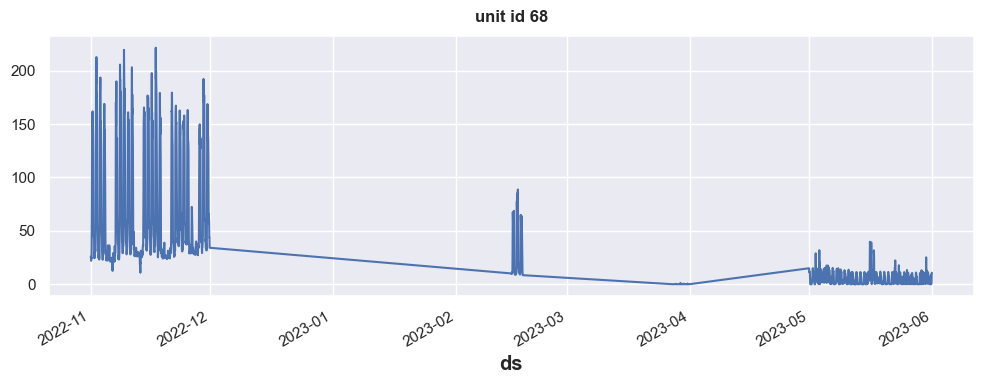

In [92]:
for id in ids_to_drop:
    plt.figure()
    plt.title(f"unit id {id}")
    df[df["unique_id"] == id].set_index("ds")["y"].plot()